# Testing Backtrader with SMA, EMA, BB and RSI Strategy Classes

In [33]:
%matplotlib inline
import numpy as np
import backtrader as bt 
from datetime import datetime, timedelta
import os
import sys
import matplotlib
import matplotlib.pyplot as plt

### Learning BackTrader Strategy Blueprint

### Notes:
- self.datas is a list that stores the different data feeds added to the Cerebro engine.
self.datas[0] refers to the first (or primary) data feed. If you add multiple data feeds, they would be indexed as self.datas[1], self.datas[2], and so on.

- self.dataclose = self.datas[0].close assigns the closing price series to self.dataclose.

- If you did self.dataopen = self.datas[0].open, you would be able to access the opening prices as well

#### Self.dataclose:
- self.dataclose[0] refers to the current bar's closing price (the latest one in the iteration).
- self.dataclose[-1] refers to the previous bar's closing price.
- self.dataclose[-2] refers to the closing price two bars ago, and so on.
- self.dataclose is not a list that is appended to, but rather a time-series reference that shifts automatically with each iteration.

#### How BackTrader Works:
- self.datas[0] is the primary data feed and given the csv file or any other method of data, it will iterate over it one by one assigning the current row to self.datas[0] and then you can access the open, high, low, close and other metrics depending on the data.
- Then, using this, you can assign values to variables in the init method for a given iteration which will change in the later iterations.
- After the values are assigned, backtrader will execute the next method which includes all of the trading logic and then move onto the next interation with the next row of the datafeed and now that becomes the new value for self.datas[0]

#### Order Class:
- keep in mind that the order passed into the notify_order method is different from self.order
- self.order keeps track of pending orders whereas order is an instance of the Order class which sits in the parent bt.Strategy class.
- order object has a lot of methods including order.executed.price which returns the executed price and the others ones as shown in the code below

In [34]:
#bt.Strategy is a parent class of this child class which is a Strategy the user creates 
class TestStrategy(bt.Strategy):

    params = (
        ('exitbars', 5),
        ('sma_slow_period', 100),
        ('sma_fast_period', 50),
    )
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    # this method initializes all of the instance variables
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # need a variable that keeps track of pending orders
        # all orders that have not been completed or accepted are stores in self.order
        self.order = None 

        # we want to see the buy price and the commision for each trade as well; these are only for logging purposes
        self.buyprice = None
        self.buycomm = None

        #if you want to add any indicators, you can add them in the init method
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], 
                                                     period = self.params.sma_slow_period)

    def notify_order(self, order):

        # means that the order has been submitted or accepted by the broker in which case there is nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return

        # now we must check if the order has been completed
        # note: the broker can reject the order due to insufficient cash

        if order.status in [order.Completed]:

            # if the order has been completed, we now just have to log it and the log will be different depending on if the order is a buy or sell

            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            elif order.issell():
                self.log(
                    'SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
            # now for this strategy, we need to keep in mind the bar at which the order was executed which we can create an instance variable for
            # now because self is an iterable object that goes through the entire dataset, the length of self will be the number of rows 
            # it has traversed. So if it is on row number 10, that means len(self) will return 10 and since we are looking at daily chart 
            # values, it means 10 days since the backtest started
            self.bar_executed = len(self)
        
        #now we must deal with the case where the order is rejected
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')


        # there are no pending orders at the moment but they would be appended to this object in the next() method
        # since all of the order logic has been handles above, at the moment, there are no pending orders so set equal to None
        self.order = None


    def notify_trade(self, trade):

        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    # all trading logic goes in here
    # for this test program, we buy if the current price is lower than previous price and if previous price is lower than its previous price
    # we sell in 5 days no matter what
    def next(self):
        # Simply log the closing price of the series from the reference

        self.log('Close, %.2f' % self.dataclose[0])
        
        if self.order:

            #you dont want to place an order if there is already an order that is pending
            return

        #check to make sure we are not currently in a position
        if not self.position:

            if self.dataclose[0] < self.dataclose[-1]:
    
                if self.dataclose[-1] < self.dataclose[-2]:
    
                    #essentially just calling the log method and logging the current price at which the buy order was created
                    self.log('CREATE BUY ORDER, %.2f' % self.dataclose[0])

                    #the order variable is set to the buy order
                    self.order = self.buy()
        else:
            #if the current self object is 5 days or more ahead of the last bar where an order was executed
            if len(self) >= (self.bar_executed + self.params.exitbars):

                self.log('CREATE SELl ORDER, %.2f' % self.dataclose[0])
                self.order = self.sell()

### Make the Backtesting Engine

In [35]:
#cerebro is like the brains of backtrader as it provides the live feeds and connects strategy to backtesting framework
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

#set starting cash values
cerebro.broker.setcash(1000000.0)

modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
modpath, _ = modpath.split(r'\venv')
datapath = os.path.join(modpath, 'data_folder/nvda-1999-2014.txt')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(dataname=datapath, fromdate=datetime(1999, 1, 25), todate=datetime(2010, 4, 20),
                                    reverse=False)

# for a more realistic backtest, set the commission to 0.1% per trade
cerebro.broker.setcommission(commission=0.001)

# Add a FixedSize sizer according to the stake; says that 10 shares should be bought per trade
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.run()

Starting Portfolio Value: 1000000.00
1999-06-16, Close, 1.35
1999-06-17, Close, 1.31
1999-06-18, Close, 1.26
1999-06-18, CREATE BUY ORDER, 1.26
1999-06-21, BUY EXECUTED, Price: 1.30, Cost: 13.00, Comm 0.01
1999-06-21, Close, 1.33
1999-06-22, Close, 1.31
1999-06-23, Close, 1.33
1999-06-24, Close, 1.30
1999-06-25, Close, 1.32
1999-06-28, Close, 1.34
1999-06-28, CREATE SELl ORDER, 1.34
1999-06-29, SELL EXECUTED, Price: 1.36, Cost: 13.00, Comm 0.01
1999-06-29, OPERATION PROFIT, GROSS 0.60, NET 0.57
1999-06-29, Close, 1.35
1999-06-30, Close, 1.48
1999-07-01, Close, 1.40
1999-07-02, Close, 1.50
1999-07-06, Close, 1.50
1999-07-07, Close, 1.48
1999-07-08, Close, 1.51
1999-07-09, Close, 1.64
1999-07-12, Close, 1.71
1999-07-13, Close, 1.72
1999-07-14, Close, 1.65
1999-07-15, Close, 1.66
1999-07-16, Close, 1.69
1999-07-19, Close, 1.65
1999-07-20, Close, 1.62
1999-07-20, CREATE BUY ORDER, 1.62
1999-07-21, BUY EXECUTED, Price: 1.60, Cost: 16.00, Comm 0.02
1999-07-21, Close, 1.57
1999-07-22, Close, 

In [36]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 1000099.00


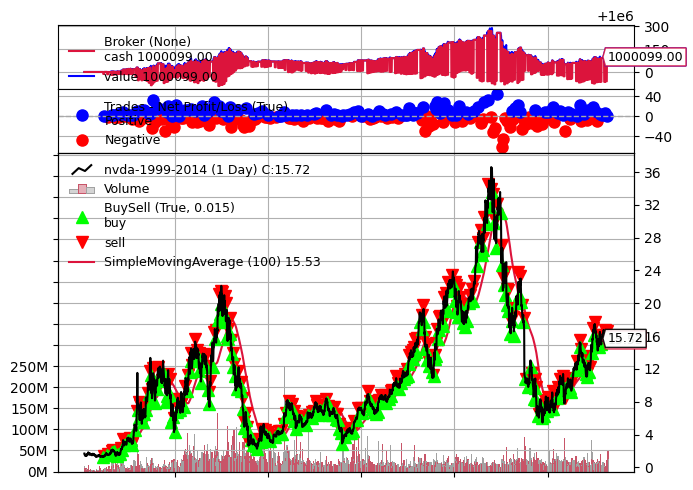

[[<Figure size 640x480 with 4 Axes>]]

In [37]:
cerebro.plot(iplot=False)